<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/%5B1%EC%A3%BC%EC%B0%A8%5D%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[심화과제] # MNIST 예측 모델에 deep learning techniques 적용하기

In [61]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## 1. 데이터셋

In [62]:
# 데이터셋 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### 1.1. Train 데이터셋
[과제] Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.

In [63]:
# CIFAR10 데이터셋 다운로드
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Files already downloaded and verified


In [64]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=256,
    shuffle=True
)

In [65]:
# WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# 이미지 데이터를 시각화 하면서 위 경고가 떠서 [-1, 1] 범위를 [0, 1]로 다시 변환하는 함수를 만듬
# 역정규화 함수 정의
def denormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.clone()  # 원본 데이터를 보존
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # std를 곱하고 mean을 더함
    return img

### 1.1.1. 데이터셋 입력 shape 확인
[과제] CIFAR10의 입력 shape 확인

In [68]:
print("[LOG]",len(trainset))
print("[LOG]",trainset[0][0].shape, trainset[0][1])

[LOG] 50000
[LOG] torch.Size([3, 32, 32]) 6


### 1.1.2. Train 데이터셋 첫 번째 이미지 확인

[LOG] Train 첫 번째 이미지 Label: 6


(-0.5, 31.5, 31.5, -0.5)

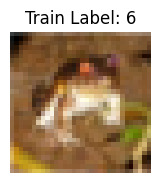

In [71]:
train_image, train_label = trainset[0]
train_image = denormalize(train_image)  # 역정규화
print("[LOG] Train 첫 번째 이미지 Label:", train_label)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_image.permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
plt.title(f"Train Label: {train_label}")
plt.axis('off')

### 1.2. Test 데이터셋
[과제] batch_size = 256로 설정

In [72]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified


In [73]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    shuffle=False
)

### 1.2.1. Test 데이터셋의 첫 번째 이미지 확인

[LOG] Test 첫 번째 이미지 Label: 3


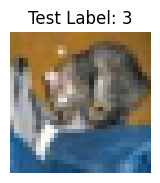

In [75]:
test_image, test_label = testset[0]
test_image = denormalize(test_image)  # 역정규화
print("[LOG] Test 첫 번째 이미지 Label:", test_label)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 2)
plt.imshow(test_image.permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
plt.title(f"Test Label: {test_label}")
plt.axis('off')
plt.show()

## 2. Model 정의
[과제] Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경해줍니다.

### 2.1.1. LeakyReLUModel

In [76]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x

### 2.1.2. SigmoidModel

In [77]:
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x

### 2.1.3. Dropout 적용한 LeakyReLUModel

In [78]:
class DropoutLeakyReLUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.LeakyReLU(0.1) # 과제적용
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)  # No activation for the output layer
        return x

### 2.2. Model의 정확도를 측정하는 코드
[과제] with torch.no_grad() 적용

In [79]:
# Accuracy 계산 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    with torch.no_grad(): # 과제 적용
        model.eval()
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

### 2.3. Model의 학습함수
[과제] model.train()을 for data in trainloader: 이전 줄에 둡니다.\
[과제] n_epochs = 50 설정

In [80]:
# 학습 함수
def train(model, optimizer, criterion, trainloader, testloader, n_epochs):
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        model.train() # 과제 적용
        total_loss = 0.0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate train and test accuracy
        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[LOG] Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Model: {model.__class__.__name__} | Optimizer: {optimizer.__class__.__name__}")

    return train_accs, test_accs

In [81]:
# plot 함수
def plot_acc(train_accs, test_accs, title, label1='train', label2='test'):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()


In [82]:
input_dim = 3 * 32 * 32  # CIFAR-10 input size
hidden_dim = 512
output_dim = 10  # 10 classes for CIFAR-10
n_epochs = 50 # 과제 적용
# Loss 함수
criterion = nn.CrossEntropyLoss()

##3. SGD와 Adam 성능 비교

In [83]:
model_sgd = LeakyReLUModel(input_dim, hidden_dim, output_dim).to('cuda')
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001)

model_adam = LeakyReLUModel(input_dim, hidden_dim, output_dim).to('cuda')
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

### 3.1. SGD Optimizer로 학습 시작

In [ ]:
print("[LOG] SGD Optimizer로 학습 시작")
sgd_train_accs = train(model_sgd, optimizer_sgd, criterion, trainloader, testloader, n_epochs)

[LOG] SGD Optimizer로 학습 시작
[LOG] Epoch 1/50 | Loss: 450.1189 | Train Acc: 0.1585 | Test Acc: 0.1528 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 2/50 | Loss: 446.3534 | Train Acc: 0.2047 | Test Acc: 0.2031 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 3/50 | Loss: 442.6701 | Train Acc: 0.2295 | Test Acc: 0.2271 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 4/50 | Loss: 438.9587 | Train Acc: 0.2396 | Test Acc: 0.2417 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 5/50 | Loss: 435.1685 | Train Acc: 0.2441 | Test Acc: 0.2457 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 6/50 | Loss: 431.3662 | Train Acc: 0.2459 | Test Acc: 0.2510 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 7/50 | Loss: 427.5288 | Train Acc: 0.2482 | Test Acc: 0.2516 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 8/50 | Loss: 423.8034 | Train Acc: 0.2510 | Test Acc: 0.2552 | Model: LeakyReLUModel | Optimizer: SGD
[LOG] Epoch 9/50 | Loss: 420.1884 | Train Acc: 0.2546 | Test 

### 3.2. Adam Optimizer로 학습 시작

In [ ]:
print("[LOG] Adam Optimizer로 학습 시작")
adam_train_accs = train(model_adam, optimizer_adam, criterion, trainloader, testloader, n_epochs)

### 3.3. 비교결과 Plot 1
[과제] SGD와 Adam 성능 비교

In [ ]:
plot_acc(sgd_train_accs, adam_train_accs, "SGD vs Adam Optimizer", label1='SGD', label2='Adam')

## 4. Leaky ReLU와 Sigmoid 성능 비교

In [ ]:
model_sigmoid = SigmoidModel(input_dim, hidden_dim, output_dim).to('cuda')
optimizer_sigmoid = optim.Adam(model_sigmoid.parameters(), lr=0.001)


### 4.1. Adam Optimizer로 학습 시작

In [ ]:
print("[LOG] Sigmoid Activation으로 학습 시작")
sigmoid_train_accs = train(model_sigmoid, optimizer_sigmoid, criterion, trainloader, testloader, n_epochs)

### 4.2. 비교결과 Plot 2
[과제] LeakyReLU와 Sigmoid 성능 비교

In [ ]:
plot_acc(adam_train_accs, sigmoid_train_accs, "LeakyReLU vs Sigmoid", label1='LeakyReLU', label2='Sigmoid')

## 5. dropout을 적용한 train과 test 정확도를 비교

In [ ]:
# Dropout model and Adam optimizer
dropout_model = DropoutLeakyReLUModel(input_dim, hidden_dim, output_dim).to('cuda')
adam_optimizer_dropout = optim.Adam(dropout_model.parameters(), lr=0.001)


### 5.1. DropoutLeakyReLUModel로 학습 시작

In [ ]:
print("[LOG] DropoutLeakyReLUModel로 학습 시작")
dropout_train_accs, dropout_test_accs = train(dropout_model, adam_optimizer_dropout, criterion, trainloader, testloader, n_epochs)

### 5.2. 비교결과 Plot 3
[과제] Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교

In [ ]:
epochs = np.arange(1, len(dropout_train_accs) + 1)
plt.plot(epochs, dropout_train_accs, label='Train Accuracy', color='blue')
plt.plot(epochs, dropout_test_accs, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy with Dropout')
plt.legend()
plt.grid(True)
plt.show()